# Business Challange

## Input

1. Challange 

    - Dashboard with net revenue forecast
    - Business Question
    
2. Business Questions   

    - Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)

    - Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?

    - Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)

    - Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

## Output

1. Data Analysis Report
2. Dashboard on Streamlit

## Tasks

 - Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.

- Qual modelo teve a melhor performance?

- Quais métricas utilizou para comparar? E por quê?

- Como realizou treino e teste?

<font size=4.5>Methodology</font>

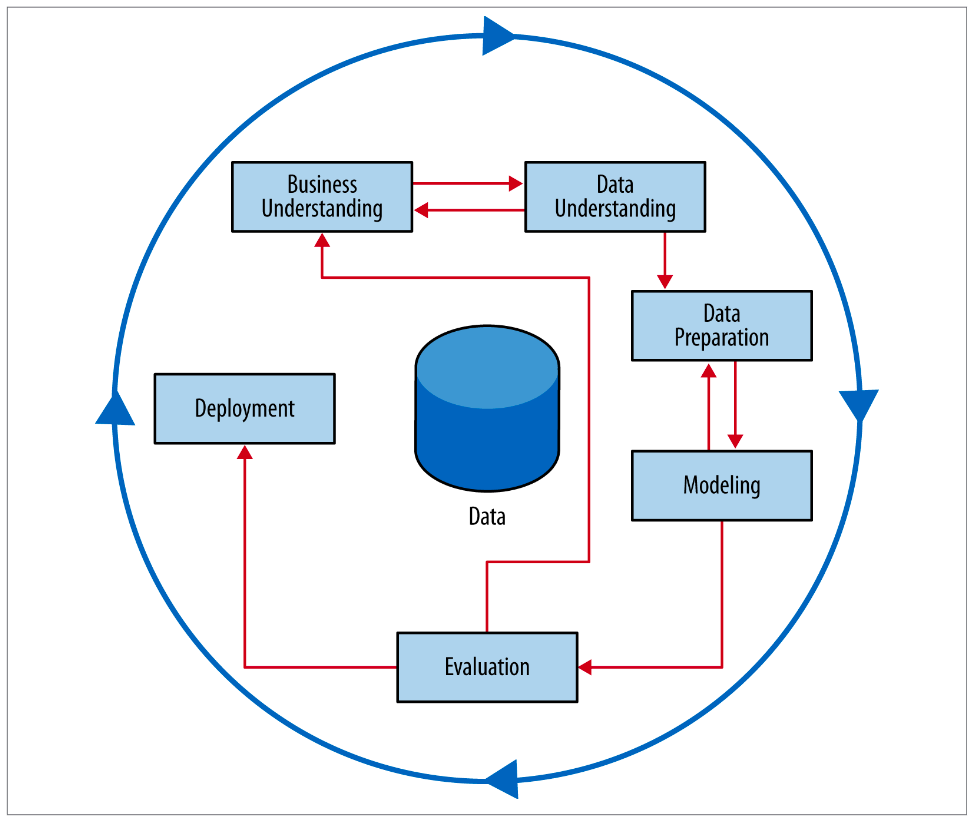

Source (PROVOST; FAWCETT, 2013)

# Dev Enviroment

## Imports

In [5]:
# Data manipulation
import re
import numpy  as np
import pandas as pd

from datetime import datetime

# Visualization
import seaborn           as sns
import plotly.express    as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tabulate        import tabulate
from prophet.plot    import plot_plotly
from IPython.display import HTML
from IPython.display import Image

# Modeling
from boruta                import BorutaPy
from sklearn.svm           import LinearSVR
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import ExtraTreesRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

# Time Series
from prophet                       import Prophet
from pmdarima.arima                import auto_arima
from statsmodels.tsa.seasonal      import seasonal_decompose
from statsmodels.tsa.stattools     import adfuller
from statsmodels.tsa.arima.model   import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Others
import logging

## Settings

In [6]:
# Figure size
plt.rcParams['figure.figsize'] = [16, 8]

# Jupyter Notebook width
display( HTML( '<style>.container { width:100% !important; }</style>') )

# Seaborn style
sns.set_style(style='darkgrid')

# Supress scientific notatino
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Logging level prophet
logging.getLogger('fbprophet').setLevel(logging.WARNING)

## Functions

### Visualizations

In [64]:
def graph_info_num(fig=None, title=str, xlabel=str, ylabel=str, x_rotation=0):
    '''
    --> Settings and information for a graph with numerical xaxis
    
    :param None fig: The figure to personalize
    :param str title: The graph title
    :param str ylabel: The Y label description
    :param str xlabel: The X label description
    :param int x_rotation: The X ticker roation
    '''
    fig.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))
    fig.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
    plt.title(title, loc='left', size=22)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=x_rotation)
    plt.show()

In [60]:
def graph_info_cat(title=str, xlabel='', ylabel='', x_rotation=0):
    '''
    --> Settings and information for a graph with categorical xaxis
    
    :param None fig: The figure to personalize
    :param str title: The graph title
    :param str ylabel: The Y label description
    :param str xlabel: The X label description
    :param int x_rotation: The X ticker roation
    '''
    plt.title(title, loc='left', size=22)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=x_rotation)
    plt.show()

### Machine Learning

In [8]:
def ml_error(model_name=None, y=None, yhat=None):
    '''
    --> Measure the performance of a model 
    
    :param model_name: The name of ML model
    :param y: The real values to validate model performance
    :param yhat: The values predicted by the model to validade
    
    return: DataFrame with the name of a model and mae, mape and mrse measures
    '''
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

## Data Raw

In [9]:
df_raw = pd.read_csv('../data/dataset.csv', sep=';')
df_raw.head()

customer_id customer_acquisition_channel  year week  net_revenue  \
0       206461               Paid Marketing  2014  W09           71   
1       462640               Paid Marketing  2015  W25           28   
2       666461                     Referral  2015  W50           40   
3       183202                     Referral  2013  W42           18   
4       410993                     Referral  2014  W29            0   

   gross_revenue  boxes  
0             71      2  
1             56     10  
2             40      1  
3             37      1  
4             37      1

# Data Description

## Data Input

In [10]:
df1 = df_raw.copy()
df1.head()

customer_id customer_acquisition_channel  year week  net_revenue  \
0       206461               Paid Marketing  2014  W09           71   
1       462640               Paid Marketing  2015  W25           28   
2       666461                     Referral  2015  W50           40   
3       183202                     Referral  2013  W42           18   
4       410993                     Referral  2014  W29            0   

   gross_revenue  boxes  
0             71      2  
1             56     10  
2             40      1  
3             37      1  
4             37      1

## Data Dimensions

In [11]:
print(f'Number of columns: {df1.shape[1]}')
print(f'Number of rows: {df1.shape[0]}')

Number of columns: 7
Number of rows: 715875


## Rename Columns

## Data Types

In [12]:
df1.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
week                            object
net_revenue                      int64
gross_revenue                    int64
boxes                            int64
dtype: object

In [ ]:
# To change
# week and year to datetime

## Missing Data

In [13]:
df1.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
week                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
dtype: int64

## Duplicates

In [14]:
df1['customer_id'].duplicated().sum()

596972

## Change Data Types

In [15]:
# Removing "W" from week number
df1['week'] = df1['week'].apply(lambda x: re.search('\d+', x).group(0))

# Year and week to datetime
# uses Monday as the first day of the week.
# Source: https://stackoverflow.com/questions/55429847/how-to-convert-string-dataframe-column-to-datetime-as-format-with-year-and-week
df1['date'] = df1['year'].astype('str') + '-' + df1['week']
df1['date'] = pd.to_datetime(df1['date'] + '-1', format='%Y-%W-%w')

# Order by date
df1.sort_values('date', inplace=True)

# Week to number
df1['week'] = df1['week'].astype('int64')

## Descriptive Statistics

## Categorical data

In [16]:
cat = df1.select_dtypes(include=['object'])

In [17]:
pd.DataFrame({'%': round(cat.value_counts(normalize=True) * 100)})

%
customer_acquisition_channel         
Paid Marketing               79.00000
Referral                     21.00000

## Numerical data

In [18]:
num = df1.select_dtypes(include=['int64'])
num = num[['net_revenue', 'gross_revenue', 'boxes']]

In [19]:
desc = num.describe().T

# Range
_range = pd.Series(num.max() - num.min(), name='range')

# Skew
skew = pd.Series(num.skew(), name='skew')

# Kurtosis
kurtosis = pd.Series(num.kurtosis(), name='kurtosis')

desc = pd.concat([desc, _range, skew, kurtosis], axis=1)
desc[['min', 'max', 'range', 'mean', '50%', '25%', '75%', 'std', 'skew', 'kurtosis']]

min       max  range     mean      50%      25%      75%  \
net_revenue    0.00000 532.00000    532 36.41544 37.00000 37.00000 37.00000   
gross_revenue 14.00000 532.00000    518 41.43058 37.00000 37.00000 40.00000   
boxes          1.00000  17.00000     16  1.03471  1.00000  1.00000  1.00000   

                   std    skew  kurtosis  
net_revenue   13.64602 0.52681  10.40376  
gross_revenue  9.75250 3.43506  36.80708  
boxes          0.19049 6.73593 118.66331

## Data Output

In [20]:
df1.to_csv('../data/df1.csv', index=False)

# Feature Engineering

## Data Input

In [21]:
df4 = pd.read_csv('../data/df1.csv')
df4['date'] = pd.to_datetime(df4['date'])
df4.head()

customer_id customer_acquisition_channel  year  week  net_revenue  \
0        74030               Paid Marketing  2013     2           37   
1        74250               Paid Marketing  2013     2           18   
2        74213               Paid Marketing  2013     2           18   
3        74100                     Referral  2013     2           18   
4        74211               Paid Marketing  2013     2           28   

   gross_revenue  boxes       date  
0             56      1 2013-01-14  
1             37      1 2013-01-14  
2             37      1 2013-01-14  
3             37      1 2013-01-14  
4             37      1 2013-01-14

## Mind Map Hypothesis

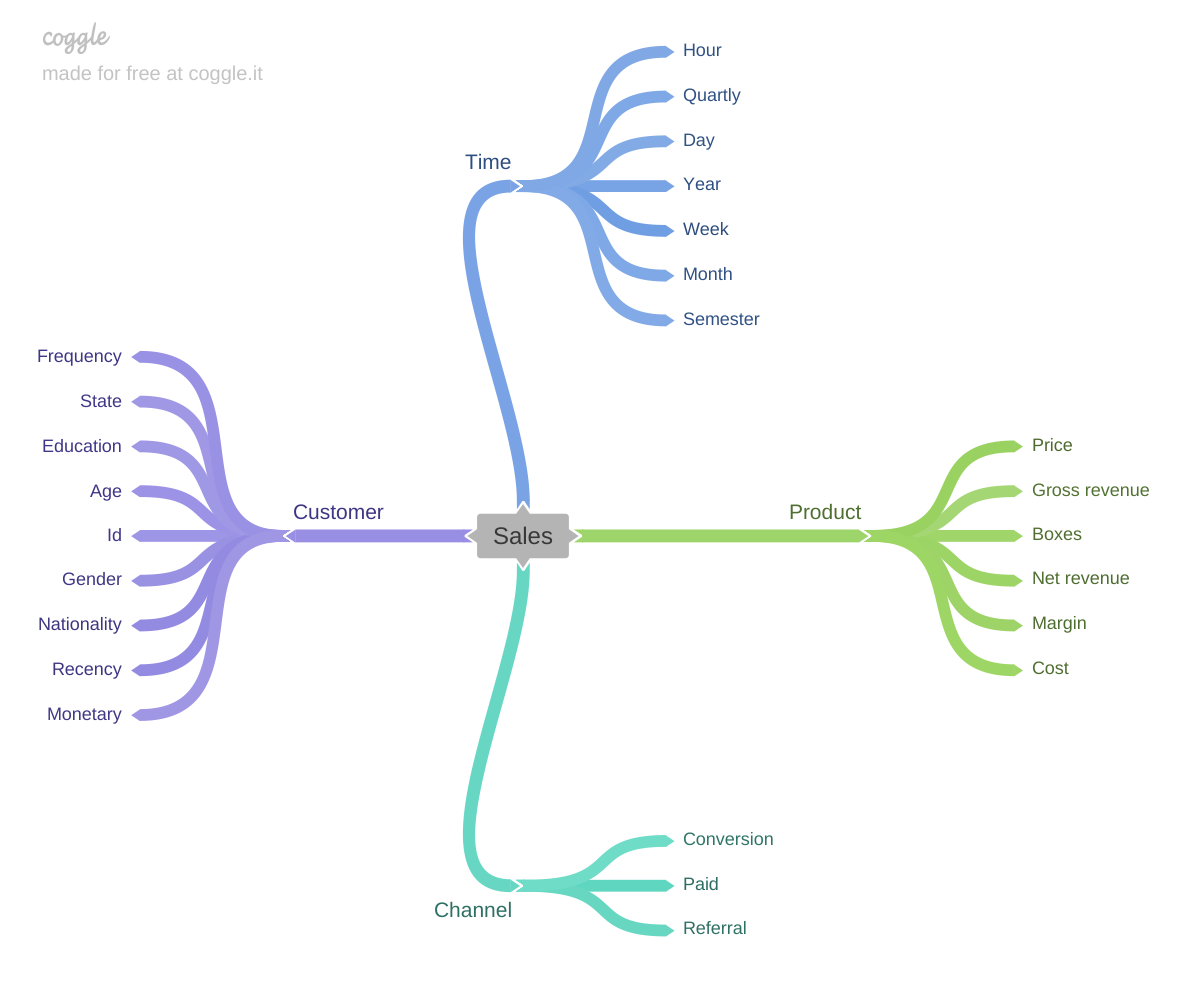

In [22]:
Image('../img/mind_map.png')

## Time Hypothesis

    H1 - Sales have increased over the years

    H2 - sales are high at christmas
    
    H3 - Sales are higher in the four quarters

## Customer Hypothesis

Obs. Data unavailable

## Channel Hypothesis

    H1 - Paid channel has higher gross revenue

## Product Hypothesis

    H1 - Net revenue increases as boxes increase
    
    H2 - The gross revenue is greater with fewer boxes

## Hypothesis List

    H1. Sales have increased over the years

    H2. sales are high at christmas

    H3. Sales are higher in the four quarters

    H4. Paid channel has higher gross revenue

    H5. Net revenue increases as boxes increase

    H6. The gross revenue is greater with fewer boxes

## Feature Derivation

In [23]:
# --------------------------------Time-----------------------------------
# Month
df4['month'] = df4['date'].dt.month

# Quarter
df4['quarter'] = df4['date'].dt.quarter

# Semester
df4['semester'] = df4['quarter'].apply(lambda x: 1 if x <= 2 else 2)

## Data Output

In [24]:
df4.to_csv('../data/feature_engineering.csv', index=False)

# Exploratory Data Analysis

## Data Input

In [25]:
df5 = pd.read_csv('../data/feature_engineering.csv')
df5.head()

customer_id customer_acquisition_channel  year  week  net_revenue  \
0        74030               Paid Marketing  2013     2           37   
1        74250               Paid Marketing  2013     2           18   
2        74213               Paid Marketing  2013     2           18   
3        74100                     Referral  2013     2           18   
4        74211               Paid Marketing  2013     2           28   

   gross_revenue  boxes        date  month  quarter  semester  
0             56      1  2013-01-14      1        1         1  
1             37      1  2013-01-14      1        1         1  
2             37      1  2013-01-14      1        1         1  
3             37      1  2013-01-14      1        1         1  
4             37      1  2013-01-14      1        1         1

## Univariate Analysis

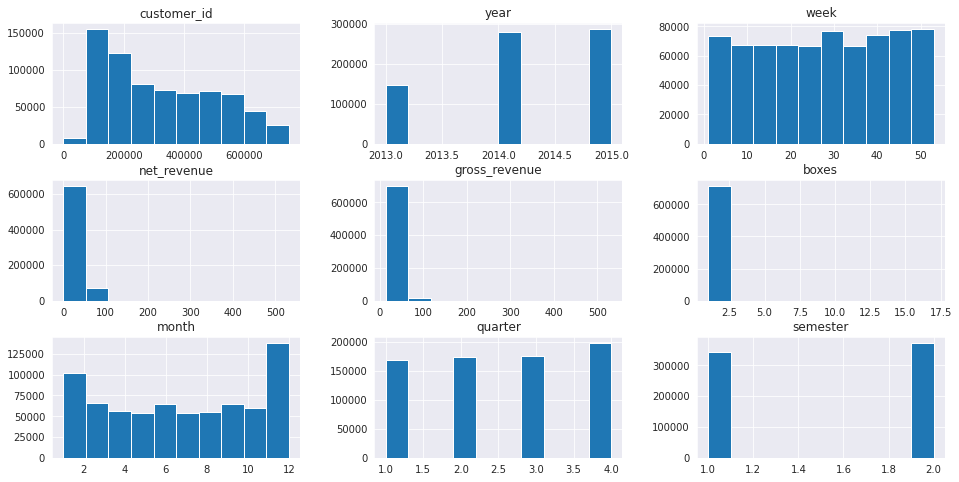

In [26]:
df5.hist()
plt.show()

## Bivariate Analysis

### H1. Sales have increased over the years

    Result: True
    Metric: Sum

In [27]:
aux = df5[['gross_revenue', 'year']].groupby('year').sum().reset_index()
px.bar(aux, x='year', y='gross_revenue', title='Gross Revenue by Year')

### H2. Sales are high at christmas

    Result: True
    Method: Gross revenue average by week

In [28]:
# All data grouped by week 
aux = df5[['week', 'gross_revenue']].groupby('week').mean().reset_index()
px.line(aux, x='week', y='gross_revenue', title='Gross Revenue Average by Week')

### H3. Sales are higher in the four quarters

    Result: True
    Method: Average

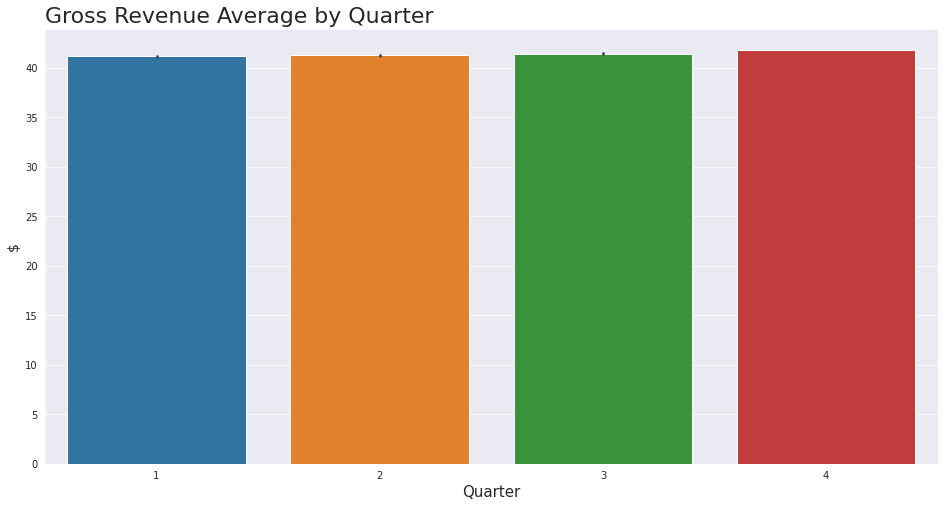

In [36]:
sns.barplot(x='quarter', y='gross_revenue', data=df5)
graph_info_cat('Gross Revenue Average by Quarter', 'Quarter', '$')

### H4. Paid channel has higher gross revenue

    Result: True
    Metric: Average

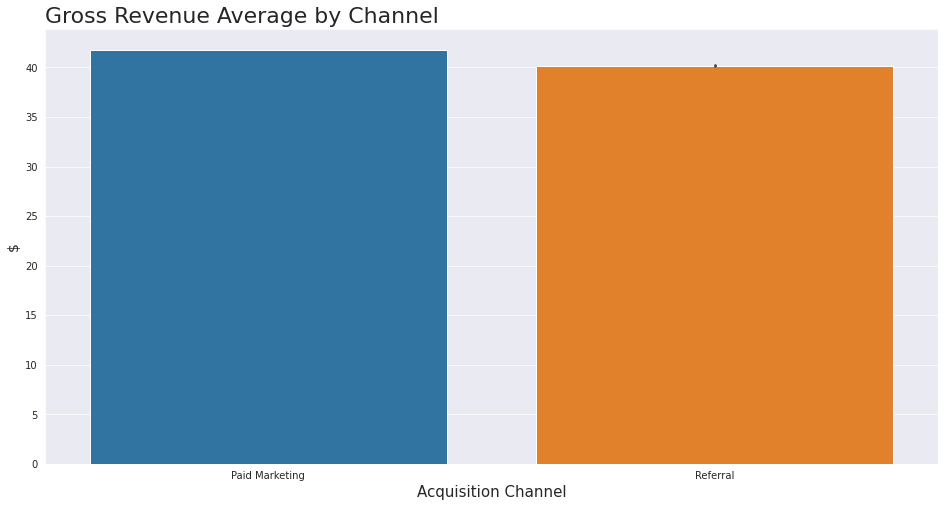

In [38]:
sns.barplot(x='customer_acquisition_channel', y='gross_revenue', data=df5)
graph_info_cat('Gross Revenue Average by Channel', 'Acquisition Channel', '$')

### H5. Net revenue increases as boxes increase

    Result: True
    Metric: Average

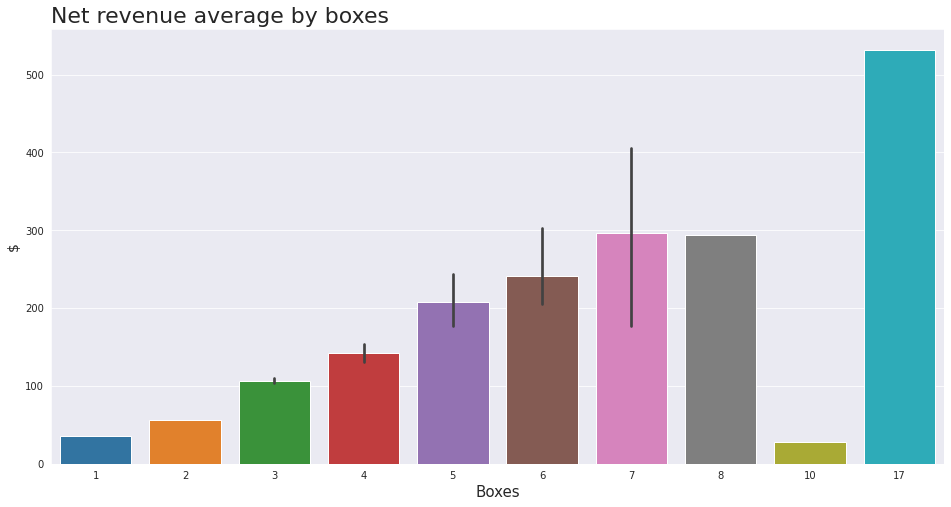

In [39]:
sns.barplot(x='boxes', y='net_revenue', data=df5)
graph_info_cat('Net revenue average by boxes', 'Boxes', '$')

### H6. The gross revenue is greater with fewer boxes

    Result: False
    Metric: Average

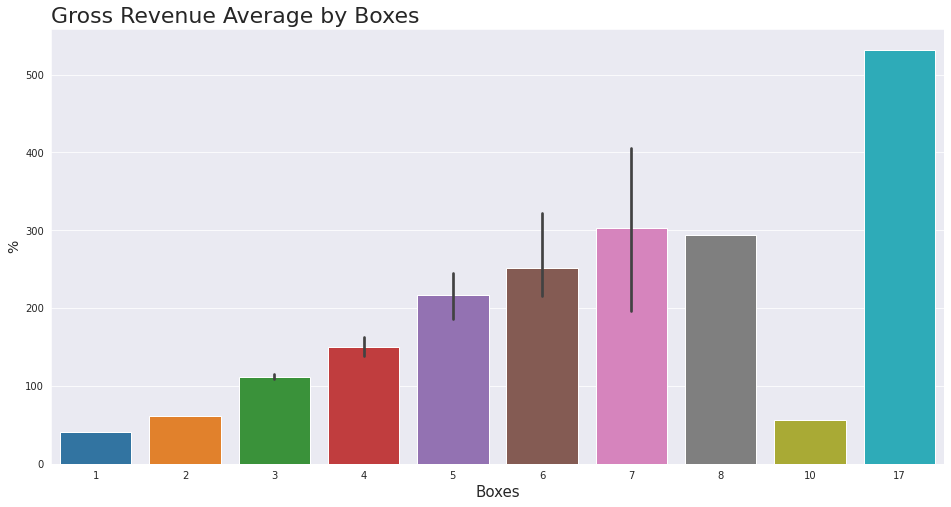

In [40]:
sns.barplot(x='boxes', y='gross_revenue', data=df5)
graph_info_cat('Gross Revenue Average by Boxes', 'Boxes', '%')

### Hypothesis Result

In [41]:
tab = [['Hypothesis', 'Result', 'Relevance'],
      ['H1. Sales have increased over the years', 'True', 'High'],
      ['H2. sales are high at christmas', 'True', 'Medium'],
      ['H3. Sales are higher in the fourth quarter', 'True', 'Low'], 
      ['H4. Paid channel has higher gross revenue', 'True', 'Low'], 
      ['H5. Net revenue increases as boxes increase', 'True', 'Medium'],
      ['H6. The gross revenue is greater with fewer boxes', 'False', 'Low']]

print(tabulate(tab, tablefmt="fancy_grid"))

╒═══════════════════════════════════════════════════╤════════╤═══════════╕
│ Hypothesis                                        │ Result │ Relevance │
├───────────────────────────────────────────────────┼────────┼───────────┤
│ H1. Sales have increased over the years           │ True   │ High      │
├───────────────────────────────────────────────────┼────────┼───────────┤
│ H2. sales are high at christmas                   │ True   │ Medium    │
├───────────────────────────────────────────────────┼────────┼───────────┤
│ H3. Sales are higher in the fourth quarter        │ True   │ Low       │
├───────────────────────────────────────────────────┼────────┼───────────┤
│ H4. Paid channel has higher gross revenue         │ True   │ Low       │
├───────────────────────────────────────────────────┼────────┼───────────┤
│ H5. Net revenue increases as boxes increase       │ True   │ Medium    │
├───────────────────────────────────────────────────┼────────┼───────────┤
│ H6. The gross revenue i

### Business Questions

#### Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)

In [42]:
aux = df5[['gross_revenue', 'year']].groupby('year').sum().reset_index()
px.bar(aux, x='year', y='gross_revenue', title='Gross Revenue by Year')

In [43]:
df5[['gross_revenue', 'year']].groupby('year').sum().reset_index()

year  gross_revenue
0  2013        6134328
1  2014       11505225
2  2015       12019567

In [44]:
aux = df5[['net_revenue', 'year']].groupby('year').sum().reset_index()
px.bar(aux, x='year', y='net_revenue', title='Net Revenue by Year')

In [45]:
df5[['net_revenue', 'year']].groupby('year').sum().reset_index()

year  net_revenue
0  2013      5295828
1  2014     10161460
2  2015     10611613

In [46]:
aux = df5[['boxes', 'year']].groupby('year').sum().reset_index()
px.bar(aux, x='year', y='boxes', title='Boxes by Year')

In [47]:
df5[['boxes', 'year']].groupby('year').sum().reset_index()

year   boxes
0  2013  156289
1  2014  291647
2  2015  292787

#### Qual customer_acquisition_channel teve maior Ticket Médio em 2013 e em 2015?

In [48]:
aux_13_15 = df5[df5['year'].isin([2013, 2015])]

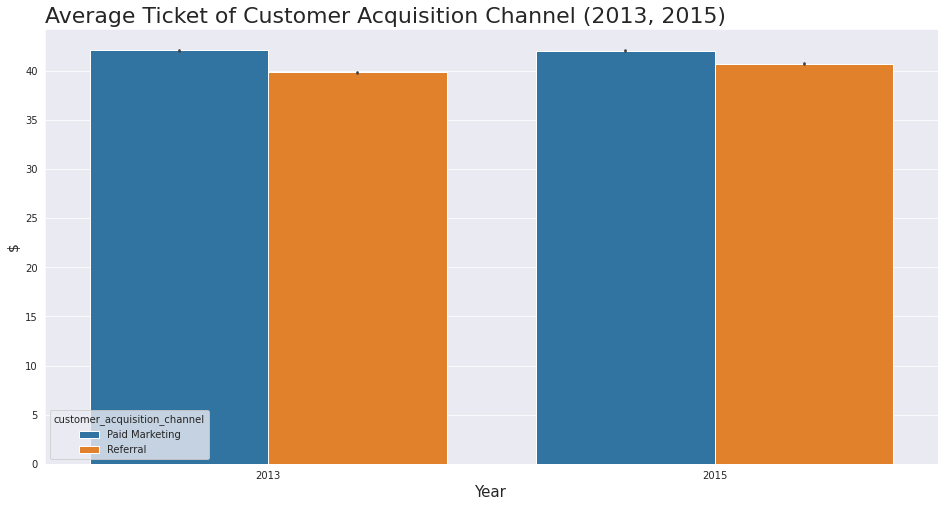

In [50]:
sns.barplot(x='year', y='gross_revenue', hue='customer_acquisition_channel', data=aux_13_15)
graph_info_cat('Average Ticket of Customer Acquisition Channel (2013, 2015)', 'Year', '$')

In [53]:
round(pd.crosstab(index=aux_13_15['year'], columns=aux_13_15['customer_acquisition_channel'], values=aux_13_15['gross_revenue'], aggfunc='mean'), 1)

customer_acquisition_channel  Paid Marketing  Referral
year                                                  
2013                                42.10000  39.80000
2015                                42.00000  40.70000

#### Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)

In [54]:
n_customers = aux_13_15.groupby('year').agg({'customer_id': pd.Series.nunique}).reset_index()

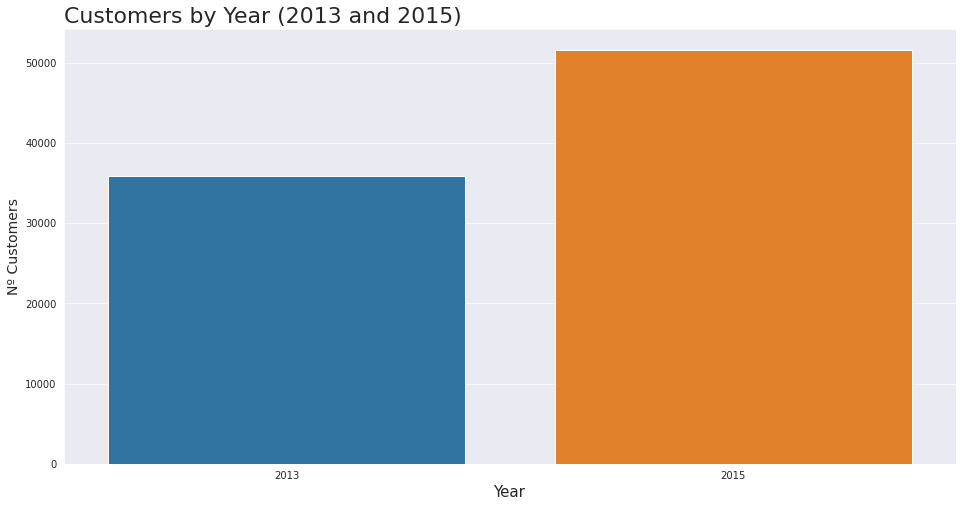

In [55]:
sns.barplot(x='year', y='customer_id', data=n_customers)
graph_info_cat('Customers by Year (2013 and 2015)', 'Year', 'Nº Customers')

In [56]:
n_customers

year  customer_id
0  2013        35851
1  2015        51643

#### Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

    - Customers
        1. Age
        2. Gender
        3. Education
        4. Nationality
        5. Lat/ log
    
    - Sales
        1. Payment Way
        2. Installments
        3. Transaction cost
        4. Freight
        5. Promotional period
        
    - Channel
        1. Smartphone
        2. Notebook
        3. Tablet
        4. Local Store

## Multivariate Analysis

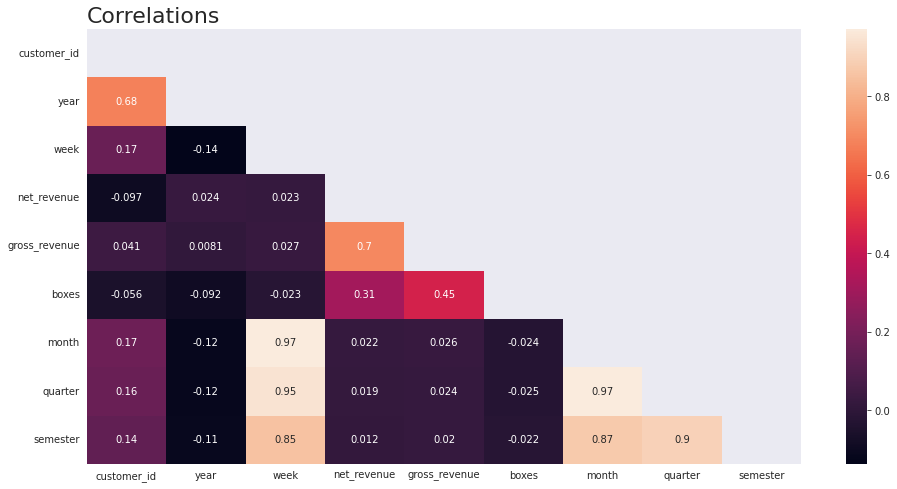

In [61]:
corr = df5.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True)
graph_info_cat('Correlations')

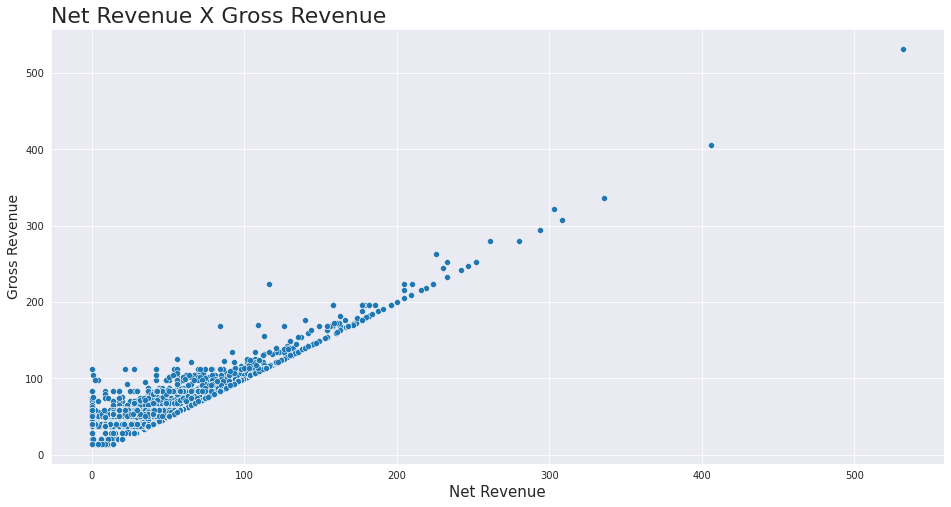

In [67]:
sns.scatterplot(x='net_revenue', y='gross_revenue', data=df5)
graph_info_cat('Net Revenue X Gross Revenue', 'Net Revenue', 
               'Gross Revenue')

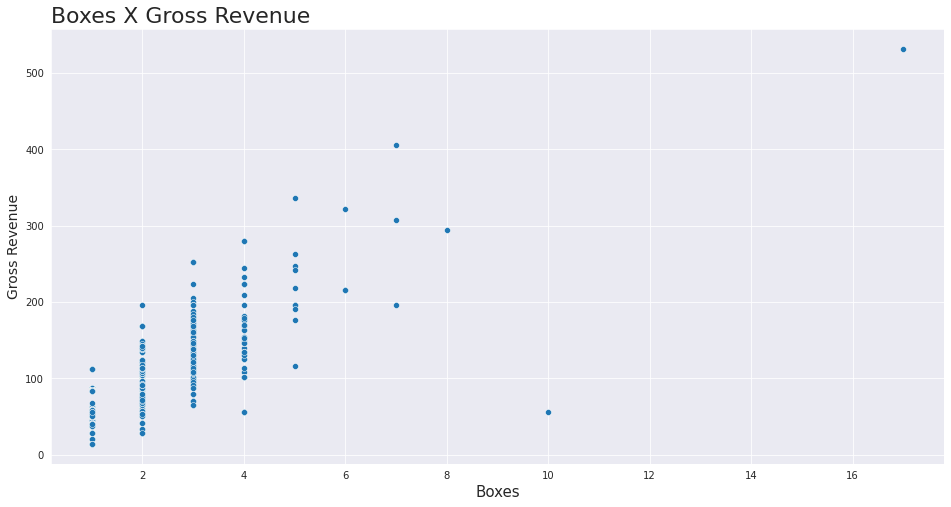

In [68]:
sns.scatterplot(x='boxes', y='gross_revenue', data=df5)
graph_info_cat('Boxes X Gross Revenue', 'Boxes', 'Gross Revenue')

# Data Preparation

## Input Data

In [69]:
df6 = pd.read_csv('../data/feature_engineering.csv')
df6['date'] = pd.to_datetime(df6['date'])
df6.head()

customer_id customer_acquisition_channel  year  week  net_revenue  \
0        74030               Paid Marketing  2013     2           37   
1        74250               Paid Marketing  2013     2           18   
2        74213               Paid Marketing  2013     2           18   
3        74100                     Referral  2013     2           18   
4        74211               Paid Marketing  2013     2           28   

   gross_revenue  boxes       date  month  quarter  semester  
0             56      1 2013-01-14      1        1         1  
1             37      1 2013-01-14      1        1         1  
2             37      1 2013-01-14      1        1         1  
3             37      1 2013-01-14      1        1         1  
4             37      1 2013-01-14      1        1         1

## Data Split

In [70]:
# --------------------------------------------Train------------------------------------ 
# 2013 to first semester of 2015
train = df6[df6['date'] < '2015-07-01'].reset_index(drop=True).copy()

# --------------------------------------------Test-------------------------------------
# Second semester of 2015
test = df6[df6['date'] > '2015-06-30'].reset_index(drop=True).copy()

## Encoder

In [71]:
#------------------------------------------Train------------------------------------------
# One Hot Encoding
# customer_acquisition_channel
train['customer_acquisition_channel'] = train['customer_acquisition_channel'].apply(lambda x: x.lower().replace(' ', '_'))
train = pd.get_dummies(data=train, columns=['customer_acquisition_channel'], prefix='customer_acqusition')

#------------------------------------------test--------------------------------------
test['customer_acquisition_channel'] = test['customer_acquisition_channel'].apply(lambda x: x.lower().replace(' ', '_'))
test = pd.get_dummies(data=test, columns=['customer_acquisition_channel'], prefix='customer_acqusition')

## Rescaling

In [72]:
#---------------------------------------------Train--------------------------------------------
# Min Max Scaler
mms = MinMaxScaler()

# boxes
train.loc[:, 'boxes'] = mms.fit_transform(train[['boxes']])

# gross_revenue
train.loc[:, 'gross_revenue'] = mms.fit_transform(train[['gross_revenue']])

# year
train.loc[:, 'year'] = mms.fit_transform(train[['year']])

# Semester
train.loc[:, 'semester'] = mms.fit_transform(train[['semester']])


#---------------------------------------------Test----------------------------------------
# Min Max Scaler
# boxes
test.loc[:, 'boxes'] = mms.fit_transform(test[['boxes']])

# gross_revenue
test.loc[:, 'gross_revenue'] = mms.fit_transform(test[['gross_revenue']])

# year
test.loc[:, 'year'] = mms.fit_transform(test[['year']])

# Semester
test.loc[:, 'semester'] = mms.fit_transform(test[['semester']])

## Nature Transformation

In [73]:
#---------------------------------train------------------------------------------
# week
train['week_of_year_sin'] = train['week'].apply(lambda x: np.sin(x * (2 * np.pi / 53)))
train['week_of_year_cos'] = train['week'].apply(lambda x: np.cos(x * (2 * np.pi / 53)))

# month 
train['month_sin'] = train['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
train['month_cos'] = train['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# quarter 
train['quarter_sin'] = train['quarter'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
train['quarter_cos'] = train['quarter'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))


#---------------------------------Test----------------------------------------
# week
test['week_of_year_sin'] = test['week'].apply(lambda x: np.sin(x * (2 * np.pi / 53)))
test['week_of_year_cos'] = test['week'].apply(lambda x: np.cos(x * (2 * np.pi / 53)))

# month 
test['month_sin'] = test['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
test['month_cos'] = test['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# quarter 
test['quarter_sin'] = test['quarter'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
test['quarter_cos'] = test['quarter'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

## Response Variable Transformation

In [74]:
#-----------------------------------------Log Transformation---------------------------------------
# net_revenue
# Train
train.loc[:, 'net_revenue'] = np.log1p(train['net_revenue'])

# Test
test.loc[:, 'net_revenue'] = np.log1p(test['net_revenue'])

## Drop columns

In [75]:
columns_drop = ['customer_id', 'week', 'month', 'quarter']
train.drop(columns=columns_drop, inplace=True)
test.drop(columns=columns_drop, inplace=True)

## Data Output

In [76]:
train.to_csv('../data/train.csv', index=False)
test.to_csv('../data/test.csv', index=False)

# Feature Selection

## Data Input

In [77]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## Train Validation Split

In [78]:
# Train
x_train = train.drop(columns=['net_revenue', 'date']).copy()
y_train = train['net_revenue'].copy()

# Test
x_test = test.drop(columns=['net_revenue', 'date']).copy()
y_test = test['net_revenue'].copy()

## Boruta

In [121]:
# Estimator
x_train_boruta = x_train.values.copy()
y_train_boruta = y_train.values.copy()
rf = RandomForestRegressor(n_jobs=-1)

# Selector
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=7).fit(x_train_boruta, 
                                                                                    y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	12


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	12


In [122]:
# Cols selected
boruta.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

## Feature Importance

In [123]:
# Estimator 
x_train_tree = x_train.copy()
y_train_tree = y_train.values.copy()
forest = ExtraTreesRegressor(n_estimators=100, random_state=7, n_jobs=-1)

# Fit
forest.fit(x_train_tree, y_train_tree)

ExtraTreesRegressor(n_jobs=-1, random_state=7)

Feature ranking:
                              feature  importances
0                       gross_revenue     0.556270
0        customer_acqusition_referral     0.323839
0                               boxes     0.039370
0                    week_of_year_cos     0.019157
0                    week_of_year_sin     0.018975
0                                year     0.013823
0                           month_cos     0.008900
0                         quarter_sin     0.007422
0                           month_sin     0.006834
0                         quarter_cos     0.002917
0                            semester     0.002409
0  customer_acqusition_paid_marketing     0.000084


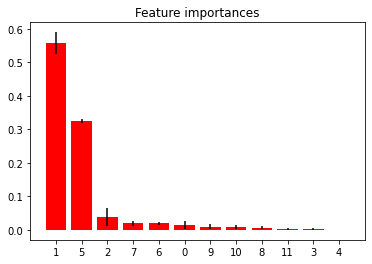

In [124]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_tree, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importances', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_tree.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_tree.shape[1]), indices)
plt.xlim([-1, x_train_tree.shape[1]])
plt.show()

## Data Output

In [79]:
# Feature Selected
cols_selected = ['date', 'customer_acqusition_referral', 'gross_revenue', 'net_revenue']
train[cols_selected].to_csv('../data/train_feature_selection.csv', index=False)
test[cols_selected].to_csv('../data/test_feature_selection.csv', index=False)

# Machine Learning

## Data Input

In [80]:
# Train
train = pd.read_csv('../data/train_feature_selection.csv')
train['date'] = pd.to_datetime(train['date'])

x_train = train.drop(columns=['net_revenue', 'date']).copy()
y_train = train['net_revenue'].copy()

# Test
test = pd.read_csv('../data/test_feature_selection.csv')

x_test = test.drop(columns=['net_revenue', 'date']).copy()
y_test = test['net_revenue'].copy()

## Average Model

In [81]:
# Mean last year
yhat_baseline = pd.DataFrame({'predictions': np.zeros_like(test['net_revenue'])})
yhat_baseline['predictions'] = train[train['date'] <= '2015-06-30']['net_revenue'].mean()


baseline_result = ml_error('Average', np.expm1(test['net_revenue']), np.expm1(yhat_baseline['predictions']))
baseline_result

Model Name      MAE                   MAPE     RMSE
0    Average 11.13472 6107111060119473.00000 14.74933

## Linear Regression

In [82]:
# Model definition
lr = LinearRegression().fit(x_train, y_train)

# Model prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result 

Model Name       MAE                    MAPE        RMSE
0  Linear Regression 276.73367 15233066779266554.00000 14216.03102

## Random Forest

In [83]:
# Model Definition
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=7).fit(x_train, y_train)

# Model prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

Model Name      MAE                    MAPE     RMSE
0  Random Forest 50.56651 15856542322323382.00000 55.24940

## XGBoost 

In [84]:
# Model definition
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10).fit(x_train, y_train)

# Prediction
yhat_xgb = xgb_model.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

Model Name      MAE                   MAPE     RMSE
0    XGBoost 19.76881 3642671385043071.50000 21.38708

## Linear SVR

In [85]:
# Model
svr = LinearSVR().fit(x_train, y_train)

# Prediction
yhat_svr = svr.predict(x_test)

# Performance
svr_result = ml_error('Linear SVR', np.expm1(y_test), np.expm1(yhat_svr))
svr_result

Model Name       MAE                    MAPE       RMSE
0  Linear SVR 230.22616 23471634571250732.00000 7872.28444

## Models Performance

In [86]:
models_performance = pd.concat([baseline_result, lr_result, rf_result, xgb_result, svr_result]).sort_values('RMSE')
models_performance

Model Name       MAE                    MAPE        RMSE
0            Average  11.13472  6107111060119473.00000    14.74933
0            XGBoost  19.76881  3642671385043071.50000    21.38708
0      Random Forest  50.56651 15856542322323382.00000    55.24940
0         Linear SVR 230.22616 23471634571250732.00000  7872.28444
0  Linear Regression 276.73367 15233066779266554.00000 14216.03102

# Time Series

## Data Input

In [87]:
df9 = pd.read_csv('../data/df1.csv', usecols=['date', 'net_revenue'])
df9 = df9[['date', 'net_revenue']] 
df9['date'] = pd.to_datetime(df9['date'])
df9.set_index('date', inplace=True)
df9 = df9.groupby(pd.Grouper(freq="M")).sum()
df9.head()

net_revenue
date                   
2013-01-31        40459
2013-02-28       171503
2013-03-31       235141
2013-04-30       349986
2013-05-31       334412

## Train and Test

In [88]:
train = df9[(df9.index >= '2014-01-01') & (df9.index < '2015-07-01')].copy()
test = df9[df9.index >= '2015-07-01'].copy()

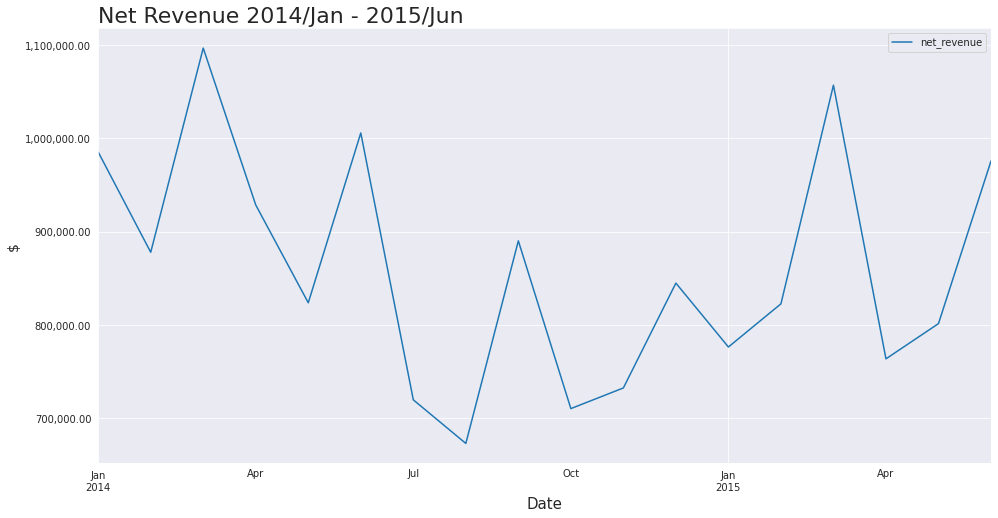

In [89]:
fig = train.plot()
graph_info(fig, 'Net Revenue 2014/Jan - 2015/Jun', 'Date', '$')

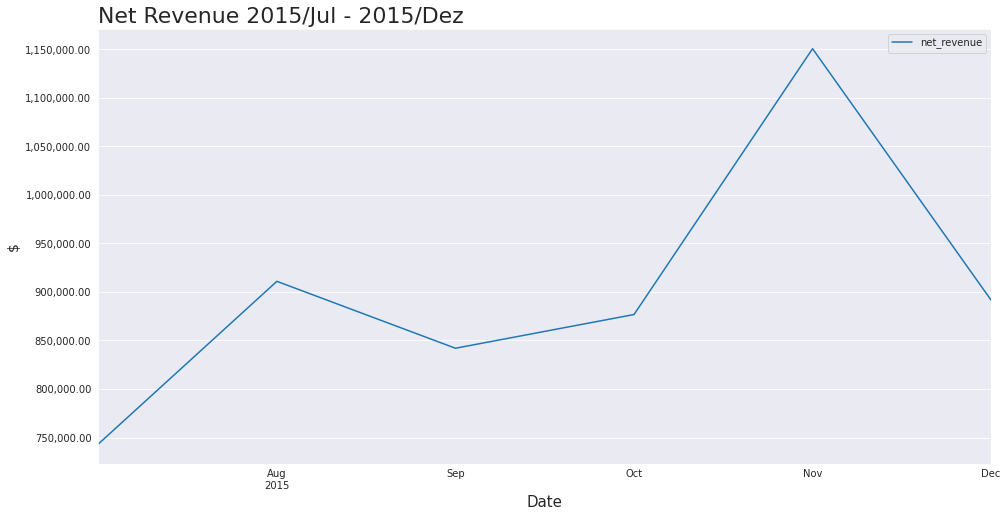

In [90]:
fig = test.plot()
graph_info(fig, 'Net Revenue 2015/Jul - 2015/Dez', 'Date', '$')

## Series Decomposition

In [91]:
px.line(df9, x=df9.index, y='net_revenue', title='Net Revenue Time Series')

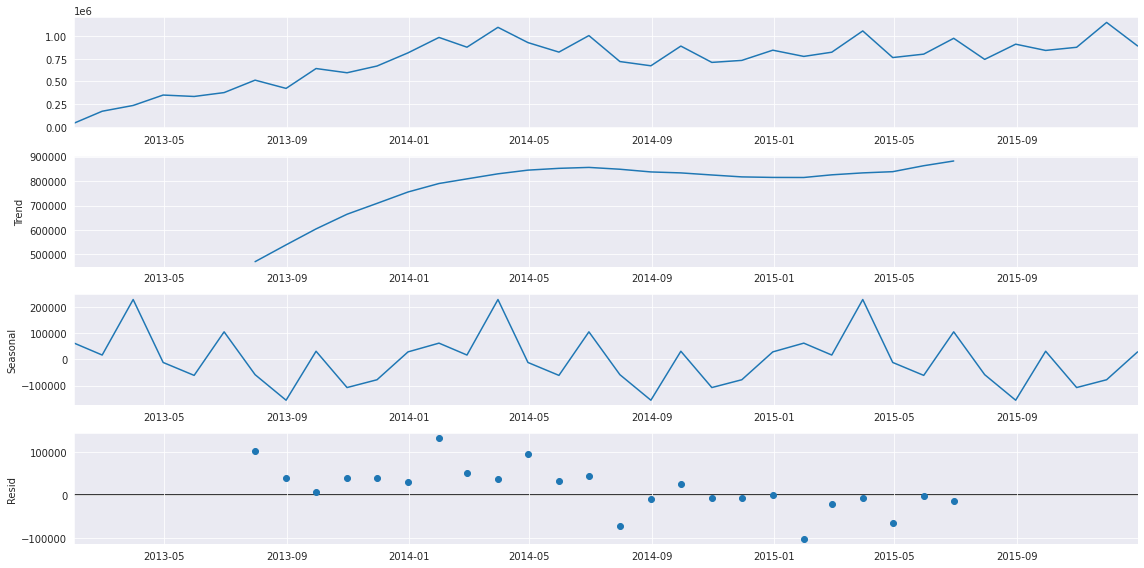

In [92]:
seasonal_decompose(df9).plot()
plt.show()

## Autocorrelation

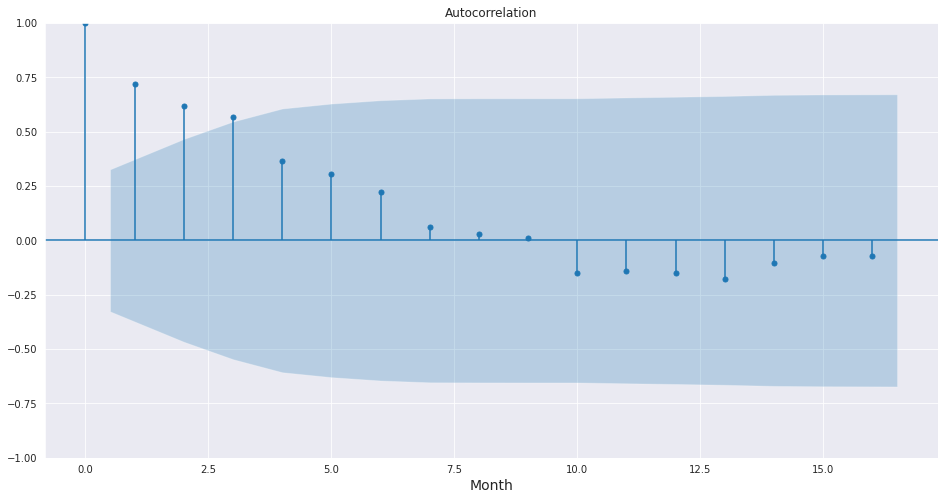

In [93]:
plot_acf(df9)
plt.xlabel('Month', fontsize=14)
plt.show()

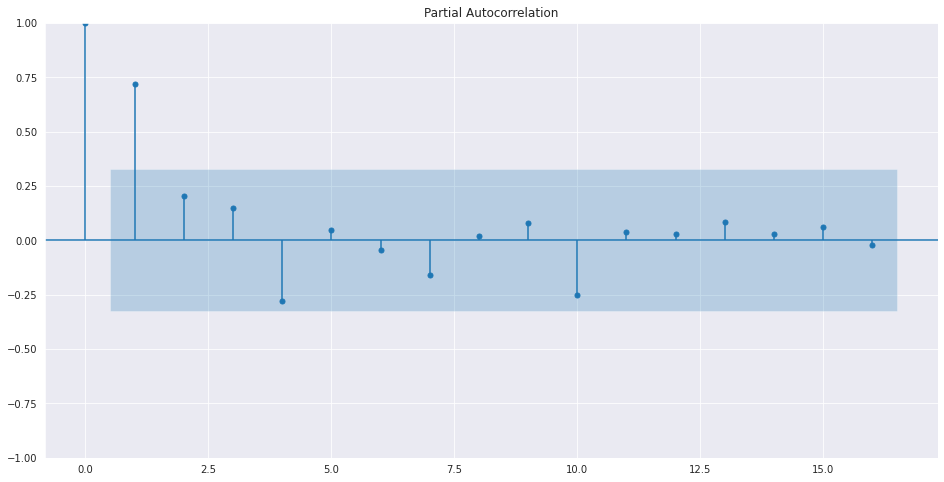

In [94]:
plot_pacf(df9['net_revenue'], method='ywm')
plt.show()

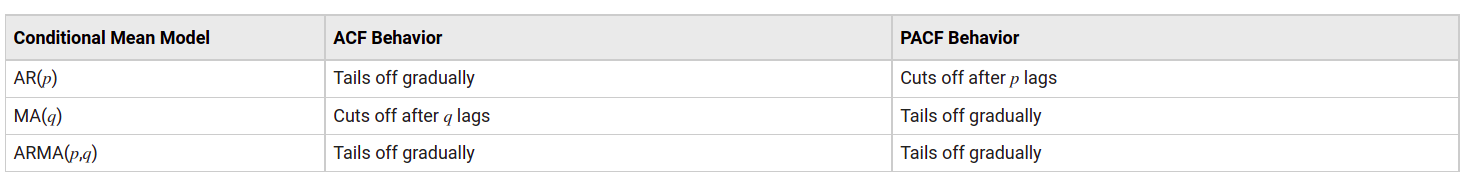

    - autoregressive models: AR(p)
    - moving average models: MA(q)
    - mixed autoregressive moving average models: ARMA(p, q)

Source: <a href="https://www.mathworks.com/help/econ/autocorrelation-and-partial-autocorrelation.html">Autocorrelation and Partial Autocorrelation</a>

## Stationarity

In [95]:
print(f"ADF Test: {adfuller(df9['net_revenue'])[0]:.2f}")
print(f"ADF p-value: {adfuller(df9['net_revenue'])[1]:.2f}")
print(f"p-value > 0.05: {adfuller(df9['net_revenue'])[1] > 0.05}")
print('Not Stationarity')

ADF Test: -1.79
ADF p-value: 0.38
p-value > 0.05: True
Not Stationarity


## Average Model

In [99]:
# Model definiiton
average_model = df9[(df9.index >= '2015-01-01') & (df9.index < '2015-07-01')].copy()

# Forecast
average_model['mean'] = average_model['net_revenue'].mean()

# Performance
average_result = ml_error('Average', test['net_revenue'], average_model['mean'])
average_result

Model Name         MAE    MAPE         RMSE
0    Average 85456.61111 0.08856 128794.56459

## Moving Average

In [100]:
# Model definition
moving_model = train['net_revenue'].rolling(6).mean()

# Forecast
moving_model = moving_model[-6:]

# Performance
moving_result = ml_error('Moving Average', test['net_revenue'], moving_model)
moving_result

Model Name         MAE    MAPE         RMSE
0  Moving Average 89523.47222 0.08841 135973.71321

## Arima

In [101]:
# Model definition
# Parameters
# order[p, d, q]
# p -  autoregressive models: AR(p)
# d - differences (stationarity)
# q - moving average models: MA(q)
modelo_arima = ARIMA(train['net_revenue'], order=[2,1,0]).fit()

# Forecast
yhat_arima = modelo_arima.forecast(6)

# Performance
arima_result = ml_error('Arima', test['net_revenue'], yhat_arima)
arima_result

Model Name          MAE    MAPE         RMSE
0      Arima 104366.43900 0.11616 126756.89176

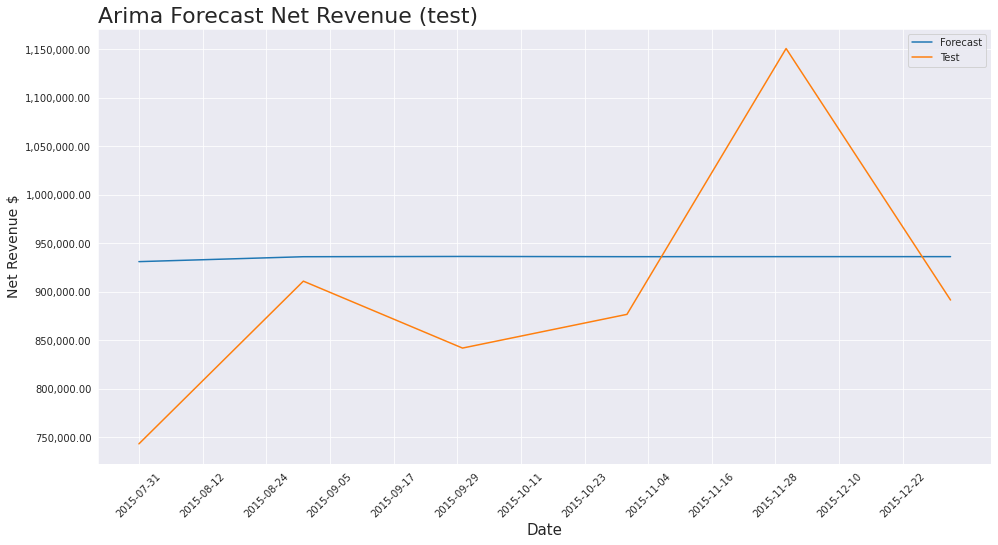

In [102]:
sns.lineplot(x=yhat_arima.index, y=yhat_arima.values, data=yhat_arima, label='Forecast')
fig = sns.lineplot(x=test.index, y='net_revenue', data=test, label='Test')
graph_info(fig, 'Arima Forecast Net Revenue (test)', 'Date', 'Net Revenue $', x_rotation=45)

## Autoarima

In [103]:
modelo_autoarima = auto_arima(train['net_revenue'], trace=True, seasonal=True)

# Forecast
yhat_autoarima = modelo_autoarima.predict(6)
yhat_autoarima

# Performance
autoarima_result = ml_error('Autoarima', test['net_revenue'], yhat_autoarima)
autoarima_result

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=482.914, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=476.692, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=478.673, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=480.381, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=545.377, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=481.323, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.085 seconds


Model Name         MAE    MAPE         RMSE
0  Autoarima 87403.64815 0.09021 130571.15417

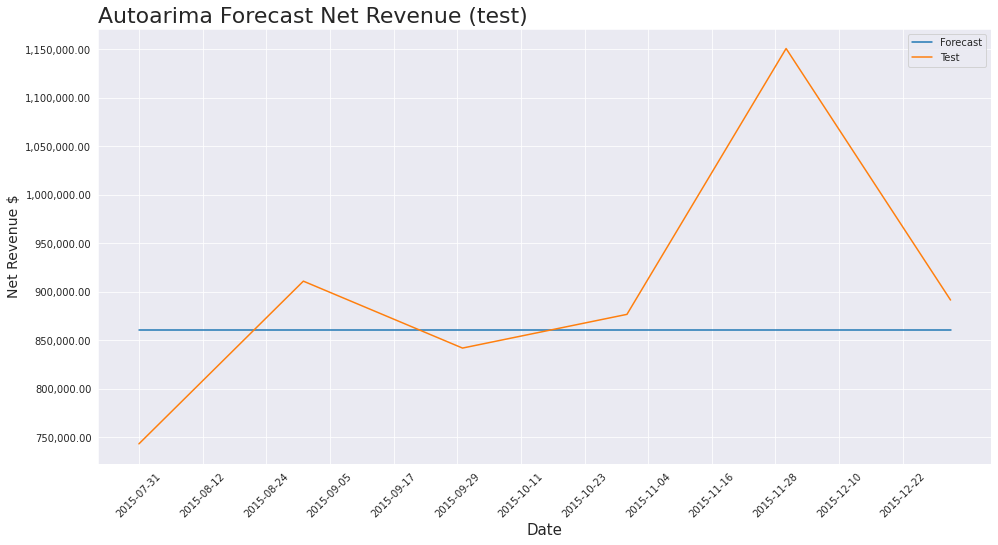

In [104]:
sns.lineplot(x=test.index, y=yhat_autoarima, label='Forecast')
fig = sns.lineplot(x=test.index, y='net_revenue', data=test, label='Test')
graph_info(fig, 'Autoarima Forecast Net Revenue (test)', 'Date', 'Net Revenue $', x_rotation=45)

## Prophet

In [105]:
# Auxiliar df
aux = train.reset_index().rename(columns={'date': 'ds', 'net_revenue': 'y'}).copy()

# Model definition and train
m = Prophet()
m.fit(aux)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.



Initial log joint probability = 4.95661
Iteration  1. Log joint probability =    15.0592. Improved by 10.1026.
Iteration  2. Log joint probability =    23.2725. Improved by 8.21331.
Iteration  3. Log joint probability =     30.533. Improved by 7.26052.
Iteration  4. Log joint probability =    30.7962. Improved by 0.263147.
Iteration  5. Log joint probability =     30.872. Improved by 0.0758365.
Iteration  6. Log joint probability =    30.8757. Improved by 0.00367643.
Iteration  7. Log joint probability =     30.876. Improved by 0.000249224.
Iteration  8. Log joint probability =    30.9217. Improved by 0.0457584.
Iteration  9. Log joint probability =    30.9266. Improved by 0.00485177.
Iteration 10. Log joint probability =    30.9549. Improved by 0.0283221.
Iteration 11. Log joint probability =    30.9664. Improved by 0.0114899.
Iteration 12. Log joint probability =    30.9687. Improved by 0.00234393.
Iteration 13. Log joint probability =     30.969. Improved by 0.000285299.
Iteration 

mproved by 0.00380813.
Iteration 15. Log joint probability =    30.9779. Improved by 0.00504978.
Iteration 16. Log joint probability =     30.983. Improved by 0.0051013.
Iteration 17. Log joint probability =    30.9839. Improved by 0.000988638.
Iteration 18. Log joint probability =    30.9877. Improved by 0.00373393.
Iteration 19. Log joint probability =    30.9888. Improved by 0.00113753.
Iteration 20. Log joint probability =    30.9916. Improved by 0.00281386.
Iteration 21. Log joint probability =    30.9926. Improved by 0.00100486.
Iteration 22. Log joint probability =     30.993. Improved by 0.000402712.
Iteration 23. Log joint probability =    30.9936. Improved by 0.000509873.
Iteration 24. Log joint probability =    30.9936. Improved by 7.20844e-05.
Iteration 25. Log joint probability =    30.9938. Improved by 0.000200559.
Iteration 26. Log joint probability =    30.9941. Improved by 0.000225999.
Iteration 27. Log joint probability =    30.9942. Improved by 0.000136998.
Iteration

In [106]:
# Prediction
future = m.make_future_dataframe(periods=6, freq='M')
forecast = m.predict(future)

# Performance
prophet_result = ml_error('Prophet', test['net_revenue'], forecast['yhat'].iloc[-6:])
prophet_result

Model Name          MAE    MAPE         RMSE
0    Prophet 129484.61282 0.13266 168248.44468

In [107]:
plot_plotly(m, forecast)

## Models Performance

In [108]:
models_performance = pd.concat([average_result,moving_result, arima_result, autoarima_result, prophet_result]).sort_values(by='RMSE')
print('Sort by RMSE')
models_performance

Sort by RMSE


Model Name          MAE    MAPE         RMSE
0           Arima 104366.43900 0.11616 126756.89176
0         Average  85456.61111 0.08856 128794.56459
0       Autoarima  87403.64815 0.09021 130571.15417
0  Moving Average  89523.47222 0.08841 135973.71321
0         Prophet 129484.61282 0.13266 168248.44468

In [109]:
print('Sort by MAE')
models_performance.sort_values('MAE')

Sort by MAE


Model Name          MAE    MAPE         RMSE
0         Average  85456.61111 0.08856 128794.56459
0       Autoarima  87403.64815 0.09021 130571.15417
0  Moving Average  89523.47222 0.08841 135973.71321
0           Arima 104366.43900 0.11616 126756.89176
0         Prophet 129484.61282 0.13266 168248.44468

In [110]:
print('Sort by MAPE')
models_performance.sort_values('MAPE')

Sort by MAPE


Model Name          MAE    MAPE         RMSE
0  Moving Average  89523.47222 0.08841 135973.71321
0         Average  85456.61111 0.08856 128794.56459
0       Autoarima  87403.64815 0.09021 130571.15417
0           Arima 104366.43900 0.11616 126756.89176
0         Prophet 129484.61282 0.13266 168248.44468

## Output Files

In [111]:
# Test data 
test.reset_index().to_csv('../data/test_time_series.csv', index=False)

# Arima forecast
yhat_arima.to_csv('../data/forecast_arima.csv', index=False)

# Error Interpretation

## Data Input

In [112]:
test = pd.read_csv('../data/test_time_series.csv')
yhat_arima = pd.read_csv('../data/forecast_arima.csv')

## Business Performance

In [113]:
# Real and predictions
df10 = pd.concat([test, yhat_arima], axis=1).rename(columns={'predicted_mean': 'predicted'})
df10['predicted'] = round(df10['predicted']).astype('int64')
df10['date'] = pd.to_datetime(df10['date'])

# MAE AND MAPE
df10['MAE'] = round(mean_absolute_error(df10['net_revenue'], df10['predicted']))
df10['MAPE'] = round(mean_absolute_percentage_error(df10['net_revenue'], df10['predicted']) * 100)

# Scenarios
df10['worst_scenario'] = round(df10['predicted'] - df10['MAE'])
df10['best_scenario'] = round(df10['predicted'] + df10['MAE'])

df10

date  net_revenue  predicted     MAE  MAPE  worst_scenario  \
0 2015-07-31       743268     931114  104366    12          826748   
1 2015-08-31       910991     936176  104366    12          831810   
2 2015-09-30       842010     936460  104366    12          832094   
3 2015-10-31       876769     936214  104366    12          831848   
4 2015-11-30      1150807     936266  104366    12          831900   
5 2015-12-31       891530     936261  104366    12          831895   

   best_scenario  
0        1035480  
1        1040542  
2        1040826  
3        1040580  
4        1040632  
5        1040627

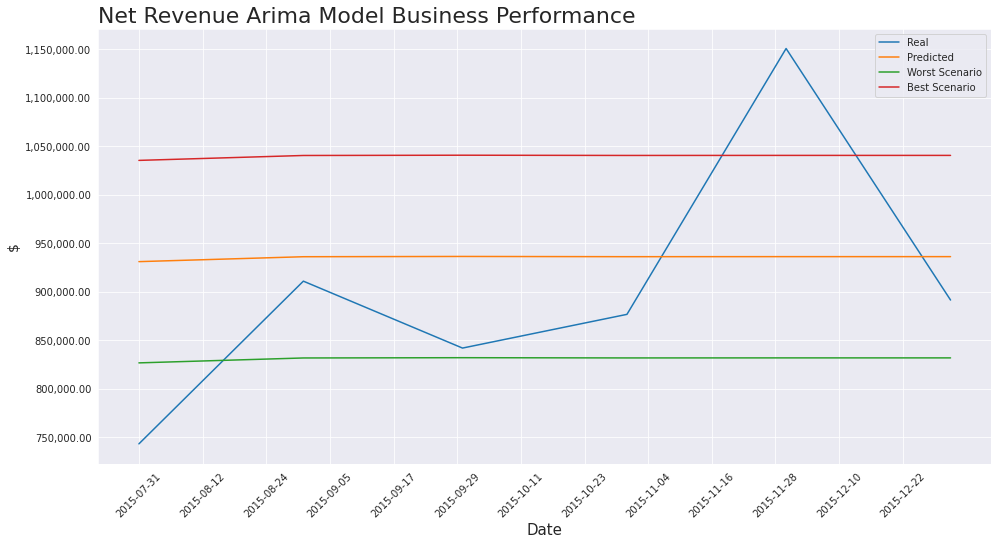

In [114]:
sns.lineplot(x='date', y='net_revenue', data=df10, label='Real')
sns.lineplot(x='date', y='predicted', data=df10, label='Predicted')
sns.lineplot(x='date', y='worst_scenario', data=df10, label='Worst Scenario')
fig = sns.lineplot(x='date', y='best_scenario', data=df10, label='Best Scenario')
graph_info(fig, 'Net Revenue Arima Model Business Performance', 'Date', '$', 45)

## Model Performance

In [115]:
df10['error'] = df10['net_revenue'] - df10['predicted']
df10['error_rate'] = df10['predicted'] / df10['net_revenue']
df10.head()

date  net_revenue  predicted     MAE  MAPE  worst_scenario  \
0 2015-07-31       743268     931114  104366    12          826748   
1 2015-08-31       910991     936176  104366    12          831810   
2 2015-09-30       842010     936460  104366    12          832094   
3 2015-10-31       876769     936214  104366    12          831848   
4 2015-11-30      1150807     936266  104366    12          831900   

   best_scenario   error  error_rate  
0        1035480 -187846     1.25273  
1        1040542  -25185     1.02765  
2        1040826  -94450     1.11217  
3        1040580  -59445     1.06780  
4        1040632  214541     0.81357

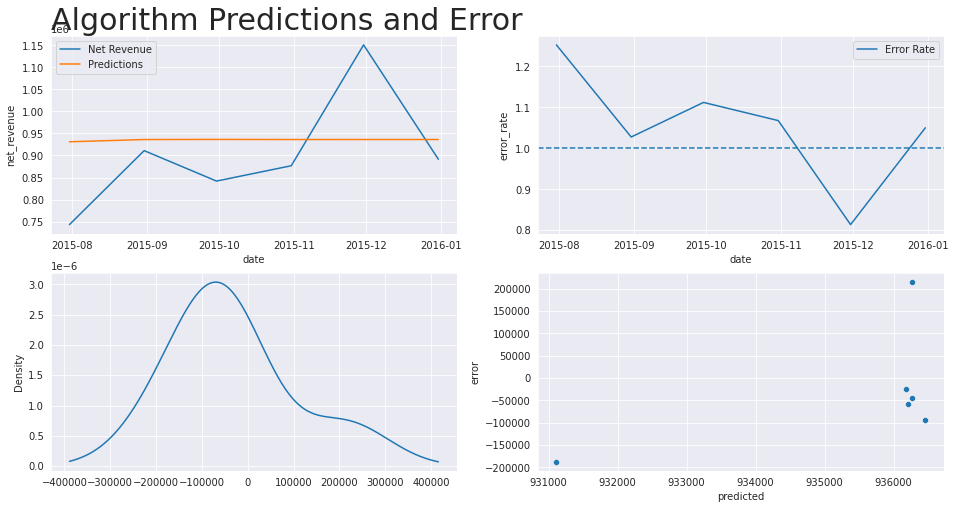

In [116]:
plt.subplot(2, 2, 1)
plt.title('Algorithm Predictions and Error', loc='left', fontsize=30)
sns.lineplot(x='date', y='net_revenue', data=df10, label='Net Revenue')
sns.lineplot(x='date', y='predicted', data=df10, label='Predictions')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df10, label='Error Rate')
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
df10['error'].plot(kind='kde')

plt.subplot(2, 2, 4)
sns.scatterplot(x='predicted', y='error', data=df10)
plt.show()

## Total Performance

In [117]:
aux = pd.DataFrame(df10[['predicted', 'worst_scenario', 'best_scenario']].sum()).reset_index().rename(columns={'index': 'Scenario', 0: 'Total 6 Months'})
aux['Total 6 Months'] = aux['Total 6 Months'].map('$ {:,.2f}'.format)
aux

Scenario  Total 6 Months
0       predicted  $ 5,612,491.00
1  worst_scenario  $ 4,986,295.00
2   best_scenario  $ 6,238,687.00

# Deploy

<font size=5><a href="https://share.streamlit.io/marcosrmg/just-challange/main/src/app.py">Streamlit Web App</a></font>